# Variational Autoencoders - Zero to Hero

![vae](vae.jpg)

Variational Autoencoders (VAEs) are a classic image generation technique. This post traces a path from simple probabilistic reasoning to VAEs. We build up the theory from Maximum Likelihood Estimation through the Expectation-Maximization (EM) algorithm, then apply these ideas to train a conditional VAE that can generate faces from simple text prompts.

## 1. Maximum Likelihood Estimation

Let's start with a simple problem. We have a coin with unknown bias $\theta$ (probability of heads). We flip it $n$ times and observe $h$ heads. Here, $x = (n,h)$ is called the data and $\theta$ is called the parameter.
Since each coin toss is independent, the probability of this set of outcomes is:

$$
p(x|\theta) = \theta^h (1 - \theta)^{n-h}
$$

How can we use this to find the most $likely$ value of $\theta$? Intuitively, it should be the one that maximizes the probability of the observed data, $p(x|\theta)$. So we reinterpret $p(x|\theta)$ as $L(\theta)$, called the likelihood. This gives us the maximum likelihood estimate (MLE).

**Example:** With 7 heads in 10 flips, we have $L(\theta) = \theta^7 (1-\theta)^3$.
To maximize $L(\theta)$, we take the log (for easier differentiation) and set the derivative to zero:

$$
\ell(\theta) = h \log \theta + (n-h) \log(1-\theta) \\
\Rightarrow \frac{d\ell}{d\theta} = \frac{h}{\theta} - \frac{n-h}{1-\theta} = 0
$$

Solving:

$$
\begin{align*}
\hat{\theta}_{MLE} = \frac{h}{n} \\
\end{align*}
$$

The MLE in this case is simply the observed fraction of heads: $\hat{\theta}_{MLE} = h/n$.

Let's simulate $n=10,000$ coin tosses below.

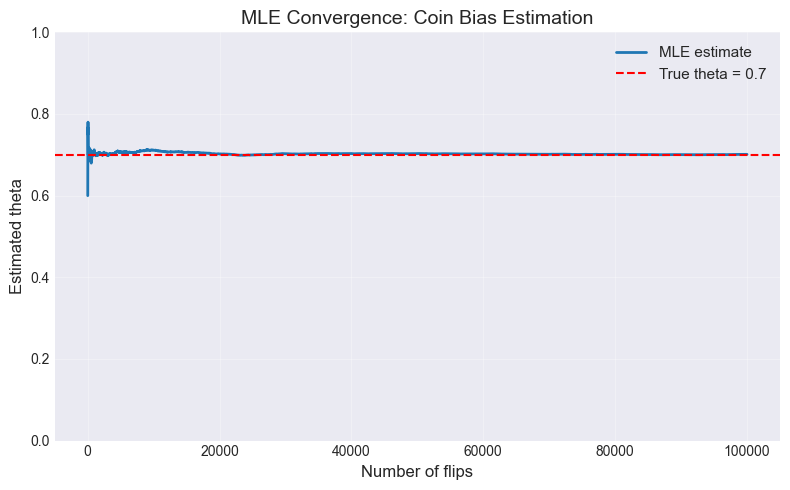

In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-darkgrid')
# Set random seed for reproducibility
np.random.seed(42)

# True coin bias (unknown in practice, known here for demonstration)
true_theta = 0.7

# Simulate coin flips
n_flips = 100000
coin_flips = np.random.binomial(1, true_theta, n_flips)

# MLE estimate: fraction of heads
n_heads = np.sum(coin_flips)
theta_mle = n_heads / n_flips

# Visualize convergence as we get more data
theta_estimates = []
sample_sizes = range(10, n_flips + 1, 10)

for n in sample_sizes:
    partial_flips = coin_flips[:n]
    theta_est = np.sum(partial_flips) / n
    theta_estimates.append(theta_est)

# Plot convergence
plt.figure(figsize=(8, 5))
plt.plot(sample_sizes, theta_estimates, label='MLE estimate', linewidth=2)
plt.axhline(y=true_theta, color='r', linestyle='--', label=f'True theta = {true_theta}')
plt.xlabel('Number of flips', fontsize=12)
plt.ylabel('Estimated theta', fontsize=12)
plt.title('MLE Convergence: Coin Bias Estimation', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()



Notice how the estimate gets more accurate with the number of flips. Next, let's plot the log-likelihood function for different values of $\theta$.

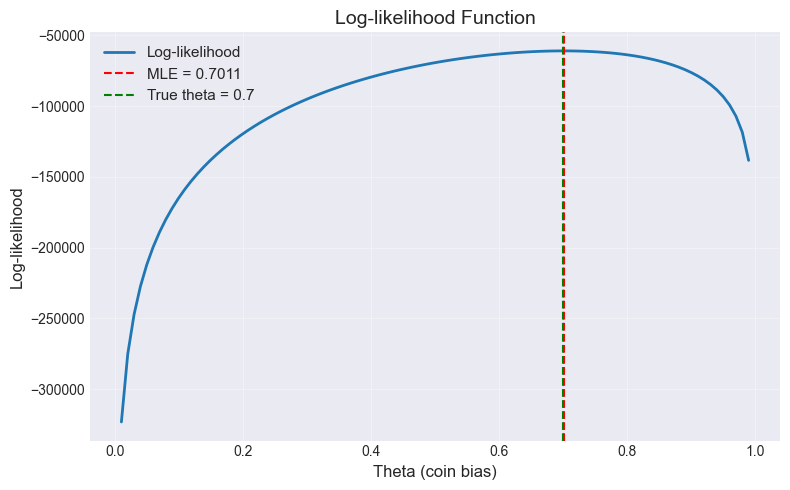

In [2]:
# Likelihood function visualization
theta_range = np.linspace(0.01, 0.99, 100)
log_likelihoods = []

for theta in theta_range:
    # Log-likelihood: h*log(theta) + (n-h)*log(1-theta)
    log_likelihood = n_heads * np.log(theta) + (n_flips - n_heads) * np.log(1 - theta)
    log_likelihoods.append(log_likelihood)

# Plot likelihood
plt.figure(figsize=(8, 5))
plt.plot(theta_range, log_likelihoods, linewidth=2, label='Log-likelihood')
plt.axvline(x=theta_mle, color='r', linestyle='--', label=f'MLE = {theta_mle:.4f}')
plt.axvline(x=true_theta, color='g', linestyle='--', label=f'True theta = {true_theta}')
plt.xlabel('Theta (coin bias)', fontsize=12)
plt.ylabel('Log-likelihood', fontsize=12)
plt.title('Log-likelihood Function', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Notice that the maxima of the log-likelihood is at the true $\theta$.

## 2. Inference with Known Parameters

Now we flip the setup: the parameter $\theta$ is known, but some data is hidden. Suppose we flipped the coin $n$ times, but $k$ outcomes are missing. We observed $h_{obs}$ heads in the $n-k$ observed flips. The $k$ missing flips are called a latent variable, $z$.

We want the distribution of the missing flips given what we observed: $p(z | x_{obs}, \theta)$. In general, this could depend on the observed data. However, coin flips are independent i.e each toss doesn't affect the others. So the missing flips follow the same distribution regardless of what we observed: $p(z | x_{obs}, \theta) = p(z | \theta)$.

The number of heads among the $k$ missing flips follows a Binomial distribution:

$$p(i \text{ heads in missing} | \theta) = \binom{k}{i} \theta^i (1-\theta)^{k-i}$$

We can compute the expected value:

$$\mathbb{E}[\text{heads in missing}] = k \cdot \theta$$

We can substitute this expected value in place of the actual (unknown) count to get an estimate of the missing flips.

## 3. Two Biased Coins

So far we've worked with a single observation (one sequence of coin flips). Now consider a dataset with multiple observations.

Imagine we have $N$ sequences of coin flips. For each sequence $i$, we observe $(n_i, h_i)$ number of flips and the number of heads. But there's a twist: we have two biased coins, and we don't know which coin was used for each sequence.

This gives us:
- **Observed data:** $x_i = (n_i, h_i)$ for each sequence $i = 1, \ldots, N$
- **Latent variable:** $z_i \in \{1, 2\}$ indicating which coin was used for sequence $i$
- **Parameters:** $\theta_1, \theta_2$ (coin biases) and $\pi$ (probability of using coin 1)

**Case 1**: We know which coin was used for each sequence.
When the latent variable $z_i$ is observed, this reduces to two separate single-coin problems. For coin 1:

$$\hat{\theta}_1 = \frac{\sum_{i: z_i=1} h_i}{\sum_{i: z_i=1} n_i}$$

This is just MLE applied separately to each coin's data. Simple and tractable.

**Case 2**: We know the coin biases but not which coin was used.
Here we compute the posterior over the latent $z_i$ using Bayes' rule:

$$p(z_i | x_i, \theta) = \frac{p(x_i | z_i, \theta) p(z_i)}{p(x_i | \theta)}$$

Substituting the specific distributions:

$$p(z_i = 1 | x_i, \theta) = \frac{\pi \cdot \theta_1^{h_i} (1-\theta_1)^{n_i-h_i}}{\pi \cdot \theta_1^{h_i} (1-\theta_1)^{n_i-h_i} + (1-\pi) \cdot \theta_2^{h_i} (1-\theta_2)^{n_i-h_i}}$$

We can now infer which coin was likely used for each sequence. If $p(z_i = 1 | x_i, \theta) > 0.5$, sequence $i$ most likely came from coin 1; otherwise, coin 2.

**Case 3**: Neither the coin biases nor which coin was used is known.
This is where things get interesting. We have a chicken-and-egg problem. To estimate the coin biases ($\theta_1, \theta_2$), we need to know which sequences came from which coin. Conversely, to determine which coin generated each sequence, we need to know the coin biases.

What if we alternated between these two easy problems?
1. Start with a guess for the parameters (say, $\theta_1^{(0)} = 0.6$, $\theta_2^{(0)} = 0.4$, $\pi^{(0)} = 0.5$).
2. Compute the posterior probability $p(z_i=1|x_i, \theta^{(t)})$ that each sequence came from coin 1.
3. Using our posterior probabilities as "soft" assignments), update the parameters via weighted MLE.
4. Repeat until convergence.

This alternation is the essence of Expectation-Maximization. The E-step fills in what we don't know (which coin was used) using our current best guess; the M-step updates our guess using the filled-in data.  Each iteration improves our estimate. The E-step gives us the best possible probabilistic completion of the missing data given our current parameters; the M-step finds the best parameters given that completion. We're never fully correct, but we're always getting better.

We have three parameters to estimate: $\theta = (\theta_1, \theta_2, \pi)$, where $\pi$ is the probability of selecting coin 1.

**E-step:** Compute the posterior probability that sequence $i$ came from coin 1, given current parameters $\theta^{(t)}$:

$$w_i^{(t)} = p(z_i = 1 | x_i, \theta^{(t)}) = \frac{\pi^{(t)} \cdot (\theta_1^{(t)})^{h_i} (1-\theta_1^{(t)})^{n_i-h_i}}{\pi^{(t)} \cdot (\theta_1^{(t)})^{h_i} (1-\theta_1^{(t)})^{n_i-h_i} + (1-\pi^{(t)}) \cdot (\theta_2^{(t)})^{h_i} (1-\theta_2^{(t)})^{n_i-h_i}}$$

**M-step:** Update parameters by maximizing the expected complete-data log-likelihood:

$$Q(\theta, \theta^{(t)}) = \mathbb{E}_{p(z|x, \theta^{(t)})}[\log p(x, z | \theta)]$$

If we knew which coin was used for each sequence, the complete-data log-likelihood would be:

$$\log p(x, z | \theta) = \sum_i \left[ \mathbb{1}(z_i=1) \log(\pi \cdot p(x_i|z_i=1, \theta)) + \mathbb{1}(z_i=2) \log((1-\pi) \cdot p(x_i|z_i=2, \theta)) \right]$$

Since we don't know $z_i$, we substitute our posterior beliefs $w_i^{(t)}$ as the expected values of $\mathbb{1}(z_i=1)$:

$$Q(\theta, \theta^{(t)}) = \sum_i \left[ w_i^{(t)} \log(\pi \cdot p(x_i|z_i=1, \theta)) + (1-w_i^{(t)}) \log((1-\pi) \cdot p(x_i|z_i=2, \theta)) \right]$$

You might wonder why maximizing the expected complete-data log-likelihood helps us maximize the marginal likelihood $p(x|\theta)$ — which is what we actually want. Remarkably, this alternation guarantees the marginal likelihood never decreases. The theoretical justification involves the ELBO, which we'll explore after introducing the Variational Autoencoder. For now, trust that this weighted counting procedure climbs toward the maximum likelihood solution..

The resulting update rules are intuitive weighted averages:

$$\theta_1^{(t+1)} = \frac{\sum_i w_i^{(t)} \cdot h_i}{\sum_i w_i^{(t)} \cdot n_i}, \quad \theta_2^{(t+1)} = \frac{\sum_i (1 - w_i^{(t)}) \cdot h_i}{\sum_i (1 - w_i^{(t)}) \cdot n_i}, \quad \pi^{(t+1)} = \frac{1}{N} \sum_i w_i^{(t)}$$

Each iteration is guaranteed to increase (or maintain) the marginal likelihood of the observed data.

SETUP: Two-Coin Problem
True parameters (unknown in practice):
  θ₁ (coin 1 bias): 0.8
  θ₂ (coin 2 bias): 0.3
  π  (P(select coin 1)): 0.6

Generated 1000 sequences:
  Actually from coin 1: 598 (59.8%)
  Actually from coin 2: 402 (40.2%)
  Avg heads (true coin 1): 15.94
  Avg heads (true coin 2): 6.07

EM ALGORITHM

Initial guesses:
  θ₁⁽⁰⁾ = 0.600, θ₂⁽⁰⁾ = 0.400, π⁽⁰⁾ = 0.500
Iter  0: θ₁=0.7781, θ₂=0.3039, π=0.6215, logL=-11628.78, delta=0.178072
Iter  1: θ₁=0.7963, θ₂=0.3020, π=0.6000, logL=-11614.85, delta=0.021434
Iter  2: θ₁=0.7978, θ₂=0.3039, π=0.5966, logL=-11614.63, delta=0.003447
Iter  3: θ₁=0.7981, θ₂=0.3043, π=0.5960, logL=-11614.62, delta=0.000621
Iter  4: θ₁=0.7981, θ₂=0.3044, π=0.5959, logL=-11614.62, delta=0.000113
Iter  5: θ₁=0.7982, θ₂=0.3044, π=0.5958, logL=-11614.62, delta=0.000021
Iter  6: θ₁=0.7982, θ₂=0.3044, π=0.5958, logL=-11614.62, delta=0.000004
Iter  7: θ₁=0.7982, θ₂=0.3044, π=0.5958, logL=-11614.62, delta=0.000001

Converged after 8 iterations!

RESULTS:
Pa

/var/folders/x4/85_9sn3d1ng9q48ff6t3fw340000gn/T/ipykernel_30740/2236666087.py:217: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/x4/85_9sn3d1ng9q48ff6t3fw340000gn/T/ipykernel_30740/2236666087.py:217: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/x4/85_9sn3d1ng9q48ff6t3fw340000gn/T/ipykernel_30740/2236666087.py:218: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  plt.savefig('03_two_coin_em.png', dpi=150)
/var/folders/x4/85_9sn3d1ng9q48ff6t3fw340000gn/T/ipykernel_30740/2236666087.py:218: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.savefig('03_two_coin_em.png', dpi=150)
/Users/vikram/dev/ml-basics/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/vikram/dev/ml-basics/.venv/l

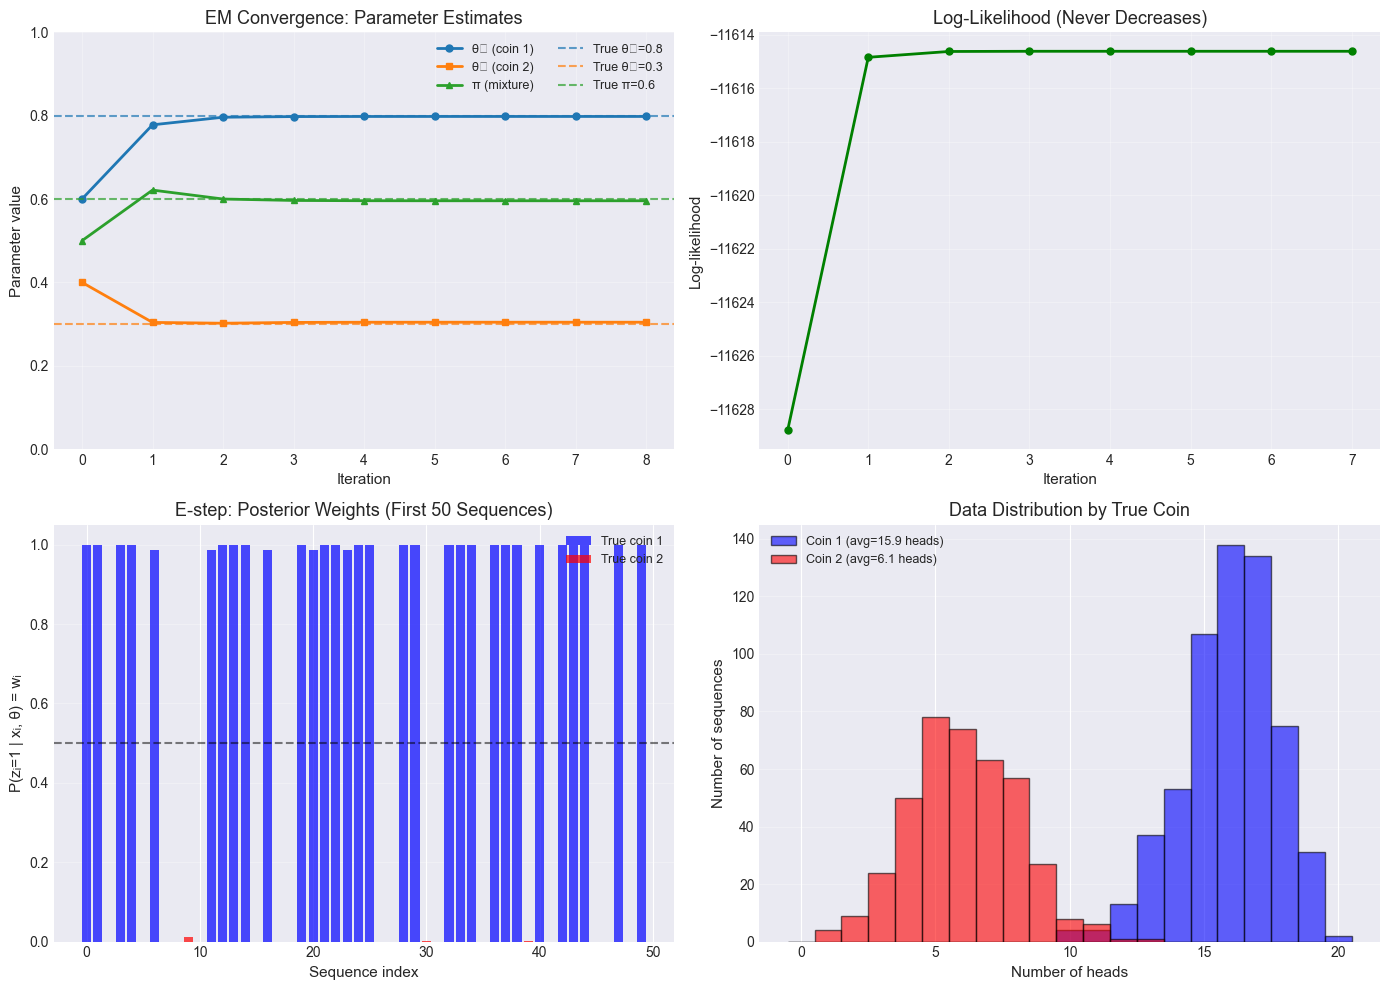

In [3]:
true_theta1 = 0.8   # Coin 1: high bias (80% heads)
true_theta2 = 0.3   # Coin 2: low bias (30% heads)
true_pi = 0.6       # 60% of sequences come from coin 1

print("=" * 60)
print("SETUP: Two-Coin Problem")
print("=" * 60)
print(f"True parameters (unknown in practice):")
print(f"  θ₁ (coin 1 bias): {true_theta1}")
print(f"  θ₂ (coin 2 bias): {true_theta2}")
print(f"  π  (P(select coin 1)): {true_pi}")

# Generate synthetic data
n_sequences = 1000
n_flips_per_seq = 20

# For each sequence, sample which coin was used, then flip that coin
data = []
true_assignments = []

for i in range(n_sequences):
    # Sample which coin (latent z_i)
    if np.random.rand() < true_pi:
        z_i = 1  # Coin 1
        theta = true_theta1
    else:
        z_i = 2  # Coin 2
        theta = true_theta2

    # Flip the selected coin n_flips_per_seq times
    flips = np.random.binomial(1, theta, n_flips_per_seq)
    heads = np.sum(flips)

    data.append({
        'n': n_flips_per_seq,
        'h': heads,
        'true_coin': z_i
    })
    true_assignments.append(z_i)

# Convert to arrays for easier handling
h_obs = np.array([d['h'] for d in data])
n_obs = np.array([d['n'] for d in data])
true_z = np.array(true_assignments)

# How many from each coin?
coin1_count = np.sum(true_z == 1)
coin2_count = np.sum(true_z == 2)

print(f"\nGenerated {n_sequences} sequences:")
print(f"  Actually from coin 1: {coin1_count} ({100*coin1_count/n_sequences:.1f}%)")
print(f"  Actually from coin 2: {coin2_count} ({100*coin2_count/n_sequences:.1f}%)")

# Average heads per sequence for each true coin
avg_heads_coin1 = np.mean(h_obs[true_z == 1])
avg_heads_coin2 = np.mean(h_obs[true_z == 2])
print(f"  Avg heads (true coin 1): {avg_heads_coin1:.2f}")
print(f"  Avg heads (true coin 2): {avg_heads_coin2:.2f}")

print("\n" + "=" * 60)
print("EM ALGORITHM")
print("=" * 60)

# Initialize parameters randomly
theta1 = 0.6
theta2 = 0.4
pi = 0.5

print(f"\nInitial guesses:")
print(f"  θ₁⁽⁰⁾ = {theta1:.3f}, θ₂⁽⁰⁾ = {theta2:.3f}, π⁽⁰⁾ = {pi:.3f}")

# EM iterations
max_iterations = 50
tolerance = 1e-6

history = {
    'theta1': [theta1],
    'theta2': [theta2],
    'pi': [pi],
    'log_likelihood': []
}

def compute_log_likelihood(h, n, theta1, theta2, pi):
    """Compute log marginal likelihood of observed data."""
    # p(x_i|z_i=1,θ) = θ₁^h * (1-θ₁)^(n-h)
    # p(x_i|z_i=2,θ) = θ₂^h * (1-θ₂)^(n-h)
    # p(x_i|θ) = π*p(x_i|z=1,θ) + (1-π)*p(x_i|z=2,θ)

    log_lik = 0
    for hi, ni in zip(h, n):
        p1 = (theta1 ** hi) * ((1 - theta1) ** (ni - hi))
        p2 = (theta2 ** hi) * ((1 - theta2) ** (ni - hi))
        marginal = pi * p1 + (1 - pi) * p2
        log_lik += np.log(marginal)
    return log_lik

for iteration in range(max_iterations):
    theta1_old, theta2_old, pi_old = theta1, theta2, pi

    # === E-STEP ===
    # Compute posterior probability w_i = P(z_i=1 | x_i, θ⁽ᵗ⁾)
    # w_i = π * θ₁^h * (1-θ₁)^(n-h) / [π * θ₁^h * (1-θ₁)^(n-h) + (1-π) * θ₂^h * (1-θ₂)^(n-h)]

    w = np.zeros(n_sequences)
    for i, (hi, ni) in enumerate(zip(h_obs, n_obs)):
        # Likelihood under coin 1
        likelihood1 = (theta1 ** hi) * ((1 - theta1) ** (ni - hi))
        # Likelihood under coin 2
        likelihood2 = (theta2 ** hi) * ((1 - theta2) ** (ni - hi))

        # Posterior (weighted by prior π)
        numerator = pi * likelihood1
        denominator = pi * likelihood1 + (1 - pi) * likelihood2
        w[i] = numerator / denominator

    # === M-STEP ===
    # Update parameters using weighted averages

    # θ₁⁽ᵗ⁺¹⁾ = Σ wᵢ*hᵢ / Σ wᵢ*nᵢ
    theta1 = np.sum(w * h_obs) / np.sum(w * n_obs)

    # θ₂⁽ᵗ⁺¹⁾ = Σ (1-wᵢ)*hᵢ / Σ (1-wᵢ)*nᵢ
    theta2 = np.sum((1 - w) * h_obs) / np.sum((1 - w) * n_obs)

    # π⁽ᵗ⁺¹⁾ = (1/N) Σ wᵢ
    pi = np.mean(w)

    # Store history
    history['theta1'].append(theta1)
    history['theta2'].append(theta2)
    history['pi'].append(pi)

    # Compute log-likelihood
    ll = compute_log_likelihood(h_obs, n_obs, theta1, theta2, pi)
    history['log_likelihood'].append(ll)

    # Check convergence
    delta = max(abs(theta1 - theta1_old), abs(theta2 - theta2_old), abs(pi - pi_old))

    if iteration < 10 or delta > tolerance * 10:
        print(f"Iter {iteration:2d}: θ₁={theta1:.4f}, θ₂={theta2:.4f}, π={pi:.4f}, "
              f"logL={ll:.2f}, delta={delta:.6f}")

    if delta < tolerance:
        print(f"\nConverged after {iteration + 1} iterations!")
        break

print("\n" + "=" * 60)
print("RESULTS:")
print("=" * 60)
print(f"{'Parameter':<15} {'Initial':<12} {'Final EM':<12} {'True':<12}")
print("-" * 60)
print(f"{'θ₁ (coin 1)':<15} {history['theta1'][0]:<12.4f} {theta1:<12.4f} {true_theta1:<12.4f}")
print(f"{'θ₂ (coin 2)':<15} {history['theta2'][0]:<12.4f} {theta2:<12.4f} {true_theta2:<12.4f}")
print(f"{'π (mixture)':<15} {history['pi'][0]:<12.4f} {pi:<12.4f} {true_pi:<12.4f}")

print(f"\nErrors:")
print(f"  θ₁ error: {abs(theta1 - true_theta1):.4f}")
print(f"  θ₂ error: {abs(theta2 - true_theta2):.4f}")
print(f"  π error:  {abs(pi - true_pi):.4f}")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Parameter convergence
ax1 = axes[0, 0]
ax1.plot(history['theta1'], 'o-', label='θ₁ (coin 1)', linewidth=2, markersize=5)
ax1.plot(history['theta2'], 's-', label='θ₂ (coin 2)', linewidth=2, markersize=5)
ax1.plot(history['pi'], '^-', label='π (mixture)', linewidth=2, markersize=5)
ax1.axhline(y=true_theta1, color='C0', linestyle='--', alpha=0.7, label=f'True θ₁={true_theta1}')
ax1.axhline(y=true_theta2, color='C1', linestyle='--', alpha=0.7, label=f'True θ₂={true_theta2}')
ax1.axhline(y=true_pi, color='C2', linestyle='--', alpha=0.7, label=f'True π={true_pi}')
ax1.set_xlabel('Iteration', fontsize=11)
ax1.set_ylabel('Parameter value', fontsize=11)
ax1.set_title('EM Convergence: Parameter Estimates', fontsize=13)
ax1.legend(fontsize=9, ncol=2)
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 1)

# Plot 2: Log-likelihood
ax2 = axes[0, 1]
ax2.plot(history['log_likelihood'], 'o-', color='green', linewidth=2, markersize=5)
ax2.set_xlabel('Iteration', fontsize=11)
ax2.set_ylabel('Log-likelihood', fontsize=11)
ax2.set_title('Log-Likelihood (Never Decreases)', fontsize=13)
ax2.grid(True, alpha=0.3)

# Plot 3: E-step weights for a sample of sequences
ax3 = axes[1, 0]
# Show first 50 sequences, color by true coin
colors = ['blue' if z == 1 else 'red' for z in true_z[:50]]
bars = ax3.bar(range(50), w[:50], color=colors, alpha=0.7)
ax3.axhline(y=0.5, color='black', linestyle='--', alpha=0.5, label='Decision boundary')
ax3.set_xlabel('Sequence index', fontsize=11)
ax3.set_ylabel('P(zᵢ=1 | xᵢ, θ) = wᵢ', fontsize=11)
ax3.set_title('E-step: Posterior Weights (First 50 Sequences)', fontsize=13)
# Legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='blue', alpha=0.7, label='True coin 1'),
                   Patch(facecolor='red', alpha=0.7, label='True coin 2')]
ax3.legend(handles=legend_elements, fontsize=9)
ax3.grid(True, alpha=0.3, axis='y')

# Plot 4: Data distribution (heads per sequence) by true coin
ax4 = axes[1, 1]
bins = np.arange(0, n_flips_per_seq + 2) - 0.5
ax4.hist(h_obs[true_z == 1], bins=bins, alpha=0.6, color='blue',
         label=f'Coin 1 (avg={avg_heads_coin1:.1f} heads)', edgecolor='black')
ax4.hist(h_obs[true_z == 2], bins=bins, alpha=0.6, color='red',
         label=f'Coin 2 (avg={avg_heads_coin2:.1f} heads)', edgecolor='black')
ax4.set_xlabel('Number of heads', fontsize=11)
ax4.set_ylabel('Number of sequences', fontsize=11)
ax4.set_title('Data Distribution by True Coin', fontsize=13)
ax4.legend(fontsize=9)
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('03_two_coin_em.png', dpi=150)


## 4. From Inference to Generation

So far we've focused on inference: given observed data, estimate unknown parameters or latents. But there's another crucial capability: generation i.e. creating new data that looks like it came from the same distribution as our training data. In the two-coin setting, this means generating new sequences of flips that could plausibly have come from our two-coin system.

1. Sample the latent: Choose which coin to use.
   $$z \sim \text{Bernoulli}(\pi)$$
   - With probability $\pi$, select coin 1.
   - With probability $1-\pi$, select coin 2.

2. Sample the data: Flip the selected coin $n$ times.
   - If $z = 1$: $h \sim \text{Binomial}(n, \theta_1)$.
   - If $z = 2$: $h \sim \text{Binomial}(n, \theta_2)$.

This is the generative process defined by $p(x, z) = p(x|z)p(z)$. The latent $z$ provides structure; the conditional $p(x|z)$ generates the actual data.

- Inference ($p(z|x)$): "Given this sequence, which coin was probably used?"
- Generation ($p(x|z)p(z)$): "Create a new sequence by first choosing a coin, then flipping it"

This duality is the foundation of generative modeling. The latents $z$ provide a compact representation that captures the essential structure of the data, enabling both understanding and synthesis.

## 5. The Curse of Dimensionality

The classical EM algorithm works beautifully for the two-coin problem because the E-step is tractable — we can compute $p(z|x, \theta)$ in closed form using Bayes' rule and the M-step has a simple closed-form solution — weighted averages for the parameters. But what happens with many possible latent values?

The two-coin problem works because $z_i$ has only 2 possible values. The E-step just computes:

$$p(z_i=1|x_i, \theta) = \frac{p(x_i|z_i=1,\theta) \cdot \pi}{p(x_i|z_i=1,\theta) \cdot \pi + p(x_i|z_i=2,\theta) \cdot (1-\pi)}$$

What if we had 100 coins instead? Now $z_i \in \{1, 2, \ldots, 100\}$. The E-step requires:

$$p(z_i=k|x_i, \theta) = \frac{p(x_i|z_i=k, \theta) \cdot p(z_i=k)}{\sum_{j=1}^{100} p(x_i|z_i=j, \theta) \cdot p(z_i=j)}$$

The denominator sums over all 100 possible coins. This is still tractable, but much slower. With 1,000 sequences and 100 coins, we're doing 100,000 evaluations per E-step.

As the number of latent possibilities grows, the E-step becomes increasingly expensive. The denominator in Bayes' rule requires summing over all possible values of $z$. With continuous latents, this sum becomes an integral over infinite space.

We need a smarter approach — one that works when we can't compute the exact posterior.

## 6. From Simple to Complex Distributions — Why We Need Neural Networks

The two-coin model works because the data is simple: we can describe the entire distribution with just three numbers ($\theta_1, \theta_2, \pi$). Sampling is straightforward because we know exactly how to sample from Bernoulli and Binomial distributions. But what about images?

Consider generating a 28×28 grayscale image (like MNIST). There are $256^{784}$ possible images — an astronomically large space. The distribution over "images that look like handwritten digits" is incredibly complex. Each pixel depends on its neighbors in complex, non-linear ways. The data contains multiple distinct classes (digits 0-9), each with its own structure. Hence, $p(x)$ has no closed-form expression.

Neural networks can learn to approximate complex functions. Instead of manually specifying $p(x|z)$, we can learn it. A neural decoder $x = f_\theta(z)$ — maps a simple latent code $z$ to a complex image $x$. The same architecture can learn to generate faces, bedrooms, or handwritten digits — just train on different data.

## 7. Autoencoders — Learning to Compress and Reconstruct

An autoencoder learns to compress data into a compact representation and then reconstruct the original from that compression. The architecture consists of two parts:
- **Encoder:** Maps input to a latent code $z = f_{\text{enc}}(x)$
- **Decoder:** Reconstructs input from the latent code $\hat{x} = f_{\text{dec}}(z)$

We train the autoencoder to minimize reconstruction error—typically MSE between input and output. The model learns to preserve only the information needed for reconstruction, discarding noise and redundancy.

Our implementation uses three convolutional layers with stride-2 downsampling in the encoder, producing a 16-dimensional latent code. The decoder uses three transposed convolutions to upsample back to a 56×56 RGB image.

Let's train this autoencoder on the Celeb-A dataset, which contains over 200,000 celebrity images.

While autoencoders excel at reconstruction, they cannot generate new images:
- The encoder maps training images to latent points, but these points occupy an irregular, non-continuous region of the latent space. Some areas encode valid images; others encode gibberish.

- To generate, we need to sample latent codes that decode to valid images. But we have no knowledge of *which* points produce valid outputs—the encoder only defines mappings for training examples.

- Interpolating between two training points in latent space often produces nonsensical outputs because the latent space lacks smooth structure.

In our implementation, we sample random latent vectors from a standard normal distribution and pass them through the decoder. The random latents fall in regions of the latent space that the decoder never learned to interpret during training.  We need a probabilistic framework that structures the latent space so sampling works.

## 8. The Variational Autoencoder

The Variational Autoencoder solves the autoencoder's sampling problem by treating the latent representation probabilistically. Instead of encoding to a single point, the encoder outputs a distribution over latents. The Decoder maps from latent space to data space: $p_\theta(x|z)$

We can interpret the VAE through the lens of the EM algorithm from Section 3. Recall that the E-step requires the posterior $p(z|x)$ — the distribution of latents given the observed data. For the coin problem, we computed this exactly using Bayes' rule. For neural networks, the true posterior is intractable because the denominator $p(x) = \int p(x|z)p(z)dz$ has no closed form. The encoder serves as an approximation $q(z|x) \approx p(z|x)$.

## 9. The Evidence Lower Bound (ELBO) — A General Framework for Approximate Inference

The EM algorithm we used in Section 3 is a special case of a more general framework called variational inference. This framework becomes essential when we can't compute the exact posterior $p(z|x)$. Instead of using the true posterior, introduce an approximate distribution $q(z)$ and optimize it to be as close as possible to $p(z|x)$, which neatly maps onto the encoder of our VAE model.

For any distribution $q(z)$, we can decompose the log marginal likelihood:

$$\log p(x) = \underbrace{\mathbb{E}_q[\log p(x, z)] - \mathbb{E}_q[\log q(z)]}_{\text{ELBO}(q)} + \underbrace{D_{KL}(q(z) \| p(z|x))}_{\text{gap}}$$

This is the Evidence Lower Bound (ELBO). It decomposes into:
1. **Expected complete-data log-likelihood:** How well $q(z)$ explains the data.
2. **Negative entropy:** Regularization that prevents $q(z)$ from becoming too concentrated.
3. **KL divergence gap:** The difference between our approximation and the true posterior.

**Key properties:**
- **Lower bound:** $\text{ELBO}(q) \leq \log p(x)$ because KL $\geq 0$.
- **Tractable:** We can compute and optimize it without marginalizing over all latents.
- **Tight when:** $q(z) = p(z|x)$ makes KL = 0, so $\text{ELBO} = \log p(x)$.

## 10. Joint Optimization with Neural Networks

**The neural network encoder:**

$$q_\phi(z|x) = \mathcal{N}(z; \mu_\phi(x), \sigma_\phi^2(x))$$

The encoder learns to predict:
- $\mu_\phi(x)$: which latent codes are likely for this image
- $\sigma_\phi(x)$: how uncertain we are about those latents

Instead of alternating E and M steps, we train both networks simultaneously:
- Forward pass: Encoder produces $q(z|x)$, decoder computes $p(x|z)$
- Compute ELBO (reconstruction term + KL term)
- Backpropagate gradients to both encoder $\phi$ and decoder $\theta$
- Update both with gradient descent.

Each training step makes small improvements to both networks. The encoder learns to produce better approximate posteriors; the decoder learns to generate better reconstructions. They co-evolve during training.

**The reparameterization trick:** To backpropagate through the sampling operation $z \sim q(z|x)$, we use:

$$z = \mu_\phi(x) + \sigma_\phi(x) \cdot \epsilon, \quad \epsilon \sim \mathcal{N}(0, I)$$

This moves the randomness outside the computation graph, allowing gradients to flow through $\mu$ and $\sigma$.

## 11. Two Views of the Same Algorithm

The ELBO framework unifies different approaches. Let's see how it applies to our two scenarios:

**View 1: Two-Coin Problem (Exact Posterior Available)**

When we CAN compute $p(z|x)$ exactly (like with two coins), we set $q(z) = p(z|x, \theta^{(t)})$:
- **E-step:** KL gap becomes zero, giving the tightest bound.
- **M-step:** Maximize $\mathbb{E}_q[\log p(x, z | \theta)]$ — this is exactly the classical EM from Section 3.

**View 2: Neural Networks (Exact Posterior Intractable)**

When we CAN'T compute $p(z|x)$ (like with neural networks), we use a neural network to approximate it:
- **Encoder:** $q_\phi(z|x) \approx p(z|x)$ — learned approximation.
- **Joint optimization:** Update both $\phi$ (encoder) and $\theta$ (decoder) using gradient descent on the ELBO.
- The KL gap is non-zero but we minimize it during training.

**The connection:** Classical EM is coordinate ascent on the ELBO when the exact posterior is available. Neural network VAEs use the same ELBO objective but with a learned approximate posterior.

## 12. A Simple VAE

We train a VAE on the CelebA dataset (56×56 face images). The encoder uses three convolutional layers with stride-2 downsampling to extract features, followed by a linear layer that outputs a 16-dimensional latent distribution (mean and log-variance). The decoder reverses this: a linear projection expands the latent code to spatial features, then three transposed convolutions upsample back to a 56×56 RGB image.

**The training objective:** The encoder approximates the true posterior $p(z|x)$ with $q_\phi(z|x) = \mathcal{N}(\mu_\phi(x), \sigma_\phi^2(x))$. We cannot maximize the marginal likelihood directly because $p(x) = \int p(x|z)p(z)dz$ is intractable. Instead, we maximize a lower bound (ELBO):

$$\log p(x) = \underbrace{\mathbb{E}_{q_\phi}[\log p(x|z)] - D_{KL}(q_\phi(z|x) \| p(z))}_{\text{ELBO}} + \underbrace{D_{KL}(q_\phi(z|x) \| p(z|x))}_{\geq 0}$$

The gap is the KL divergence between our approximate posterior and the true posterior. Since KL $\geq 0$, the ELBO is a lower bound. Maximizing the ELBO tightens this bound while improving reconstruction. The KL term $D_{KL}(q_\phi \| p(z))$ regularizes our approximate posterior toward the prior $\mathcal{N}(0,I)$.

**The reparameterization trick:** To backpropagate through the sampling operation $z \sim q(z|x)$, we rewrite it as:

$$z = \mu_\phi(x) + \sigma_\phi(x) \cdot \epsilon, \quad \epsilon \sim \mathcal{N}(0, I)$$

The randomness moves outside the computation graph (to $\epsilon$), allowing gradients to flow through $\mu$ and $\sigma$. We sample $\epsilon$ from a standard normal, scale it by the learned standard deviation, shift by the learned mean, and get our latent code — all differentiable operations.

**The KL divergence term:** For a Gaussian approximate posterior $q_\phi(z|x) = \mathcal{N}(\mu, \text{diag}(\sigma^2))$ and standard normal prior $p(z) = \mathcal{N}(0, I)$, the KL divergence has a closed-form solution:

$$D_{KL}(q_\phi(z|x) \| p(z)) = \frac{1}{2} \sum_{j=1}^{J} \left( \sigma_j^2 + \mu_j^2 - \log \sigma_j^2 - 1 \right)$$

This term penalizes deviations from the prior. If the encoder outputs $\mu = 0$ and $\sigma = 1$ for all dimensions, the KL term equals zero. As the posterior drifts from the prior, the KL term increases, pushing the encoder to keep latent codes close to the standard normal distribution while still allowing enough flexibility for reconstruction.

**What the KL term enforces geometrically:**

The KL divergence forces the latent space to resemble a **spherical Gaussian centered at the origin**:

- **Centered**: The $\mu_j^2$ term pulls all encodings toward $z = 0$
- **Unit variance**: The $\sigma_j^2 - \log \sigma_j^2$ terms keep spread around $\sigma \approx 1$ in all directions.
- **Isotropic**: No preferred direction — the prior treats all dimensions equally.

**The tension:** The encoder wants to place each image's latent far from others to make reconstruction easy. The KL term pulls all latents toward the origin. The compromise creates a "fuzzy ball" in latent space where points are spread out but stay within a few standard deviations of zero. This structure ensures any random sample from the prior decodes to a valid face, and interpolation between points produces coherent intermediate images.

The generation results are starting to somewhat resemble faces now.

In [ ]:

from dataclasses import dataclass

import jax
import jax.numpy as jnp
import flax.nnx as nnx
import numpy as np

import optax

from typing import Optional
#from jax_flow.datasets.fashion_mnist import make_dataloader, visualize_batch, FASHION_LABELS
from jax_flow.datasets.celeb_a import DataConfig, make_dataloader, visualize_batch

train_it = make_dataloader("train")

@dataclass
class Config:
    hidden_size: int = 16


class VAE(nnx.Module):
    def __init__(self, config: Config, rngs: nnx.Rngs):
        self.config = config
        self.conv1 = nnx.Conv(in_features=3, out_features=16, kernel_size=(3, 3), strides=(2, 2), padding='SAME', rngs=rngs)
        self.conv2 = nnx.Conv(in_features=16, out_features=32, kernel_size=(3, 3), strides=(2, 2), padding='SAME', rngs=rngs)
        self.conv3 = nnx.Conv(in_features=32, out_features=64, kernel_size=(3, 3), strides=(1, 1), padding='SAME', rngs=rngs)
        self.linear1 = nnx.Linear(14*14*64, 2 * config.hidden_size, rngs=rngs)
        self.linear2 = nnx.Linear(config.hidden_size, 14*14*64, rngs=rngs)
        self.deconv1 = nnx.ConvTranspose(in_features=64, out_features=32, kernel_size=(3, 3), strides=(2, 2), padding='SAME', rngs=rngs)
        self.deconv2 = nnx.ConvTranspose(in_features=32, out_features=16, kernel_size=(3, 3), strides=(2, 2), padding='SAME', rngs=rngs)
        self.deconv3 = nnx.ConvTranspose(in_features=16, out_features=3, kernel_size=(3, 3), strides=(1, 1), padding='SAME', rngs=rngs)
    

    def __call__(self, batch, key: jnp.ndarray = None):
        B, _, _, _ = batch.shape
        batch = batch.transpose(0, 2, 3, 1)
        x = self.conv1(batch)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.reshape(B, -1)
        x = self.linear1(x)
        mu, log_var = jnp.split(x, 2, axis=1)
        key, subkey = jax.random.split(key)
        epsilon = jax.random.normal(subkey, log_var.shape)
        l = mu + jnp.sqrt(jnp.exp(log_var)) * epsilon
        x = self.linear2(l)
        x = x.reshape(B, 14, 14, 64) 
        x = self.deconv1(x)
        x = self.deconv2(x)
        y = self.deconv3(x)
        assert(batch.shape == y.shape)
        y = y.transpose(0, 3, 1, 2)
        return y, mu, log_var, key


# ---------------------------
# VAE-specific generation
# ---------------------------

def decoder_wrapper(_params_unused, z, _rng=None):
    # `z` may be a numpy or jax array; decode_z returns CHW images
    imgs = decode_z(m, z)
    # convert to HWC if needed
    arr = np.array(imgs)
    if arr.ndim == 4 and arr.shape[1] in (1, 3):
        arr = arr.transpose(0, 2, 3, 1)
    return arr


def decode_z(vae: VAE, z):
    """Decode latent batch z (numpy/jax array) to images using VAE decoder layers.

    Returns images in CHW format matching the forward output.
    """
    x = vae.linear2(z)
    if hasattr(x, 'reshape'):
        B = x.shape[0]
        x = x.reshape(B, 14, 14, 64)
    x = vae.deconv1(x)
    x = vae.deconv2(x)
    y = vae.deconv3(x)
    y = y.transpose(0, 3, 1, 2)
    return y


def reconstruct_images(model, key, n_images=8, save_path=None):
    """Reconstruct real images from the dataset and display original vs reconstructed."""
    import matplotlib.pyplot as plt

    test_cfg = DataConfig(batch_size=n_images, num_epochs=1, shuffle=True, as_chw=True)
    test_it = make_dataloader("test", test_cfg)
    images, _ = next(test_it)

    reconstructed, mu, log_var, _ = model(images, key)

    # Convert to HWC for plotting
    orig = np.array(images)
    recon = np.array(reconstructed)
    if orig.shape[1] in (1, 3):
        orig = orig.transpose(0, 2, 3, 1)
        recon = recon.transpose(0, 2, 3, 1)

    fig, axes = plt.subplots(2, n_images, figsize=(n_images * 2, 4))
    for i in range(n_images):
        axes[0, i].imshow(np.clip(orig[i], 0, 1))
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_title('Original', fontsize=10)

        axes[1, i].imshow(np.clip(recon[i], 0, 1))
        axes[1, i].axis('off')
        if i == 0:
            axes[1, i].set_title('Reconstructed', fontsize=10)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
        print(f"Saved reconstruction to {save_path}")
    plt.show()



@nnx.jit
def step_fn(m, x, key):
    def loss_fn(m, x, key):
        y, mu, log_var, key = m(x, key)
        assert(y.shape == x.shape)
        loss =  jnp.sum((y - x) ** 2) + 0.5 * jnp.sum(jnp.exp(log_var) + mu ** 2 - log_var) 
        loss /= y.shape[0]
        return loss, (y, key)

    return nnx.value_and_grad(loss_fn, has_aux=True)(m, x, key)


rngs = nnx.Rngs(default=0)
config = Config()
m = VAE(config, rngs)

tx = optax.adam(1e-3)
optimizer = nnx.Optimizer(m, tx, wrt=nnx.Param)

#print(f"Total iterations: {len(train_it)}")
key = jax.random.PRNGKey(42)
for i, (x, labels) in enumerate(train_it):
    (loss, (y, key)), grads = step_fn(m, x, key)
    optimizer.update(m, grads)
    print(i, loss)

# Reconstruct real images to show VAE reconstruction quality
reconstruct_images(m, key, n_images=8, save_path="vae_reconstruction.png")

# Generate from random latents
from jax_flow.generate import plot_samples as generic_plot
generic_plot(jax.random.PRNGKey(2000), None, decoder_wrapper, n_row=4, latent_dim=config.hidden_size, save_to="vae_generation.png")


## 13. Conditioning the VAE: Text-Guided Generation

Unconditional VAEs sample random faces from $p(x)$ with no control over attributes. To generate specific types of images — a smiling person, someone with glasses — we need conditional generation: learning $p(x|c)$ where $c$ is a conditioning signal.

We use **FiLM (Feature-wise Linear Modulation)** to inject conditioning into the decoder. FiLM modulates feature maps using learned affine transformations derived from the conditioning signal:

$$\text{FiLM}(x | c) = \gamma(c) \odot x + \beta(c)$$

where $\gamma(c)$ and $\beta(c)$ are scale and shift vectors predicted from the CLIP embedding $c$ via small linear networks, and $\odot$ denotes element-wise multiplication. This allows the conditioning to amplify relevant feature channels (via scaling) and adjust activation levels (via shifting) at each decoder layer.

**CLIP** provides the conditioning vectors. This pre-trained model embeds both text and images into the same 512-dimensional space — a smiling face and the text "smiling person" map to nearby vectors. CLIP remains frozen during training; it acts as a fixed feature extractor.

The conditional ELBO becomes:

$$\mathcal{L}(\theta, \phi; x, c) = \mathbb{E}_{q_\phi(z|x)}[\log p_\theta(x | z, c)] - D_{\text{KL}}(q_\phi(z|x) \| p(z))$$

During training, we extract CLIP image embeddings for each training image and pass them through the FiLM layers in the decoder. The VAE learns to associate CLIP embedding directions with visual attributes. At inference, we encode text prompts through CLIP and generate images conditioned on those embeddings.

In [ ]:

"""
CLIP-Conditioned VAE with FiLM (Feature-wise Linear Modulation)

This implements a conditional VAE where the decoder is conditioned on CLIP embeddings
via FiLM layers. CLIP provides a joint text-image embedding space, allowing generation
from both text prompts and reference images.

Architecture:
- Encoder: Same as unconditional VAE (conv layers -> latent mu/log_var)
- Decoder: Deconv layers with FiLM conditioning at each layer
  - FiLM: x_out = scale(clip) * x + shift(clip)

Training:
- CLIP model is frozen (pre-trained)
- VAE learns to reconstruct images conditioned on their CLIP embeddings
- At inference: can use CLIP text embeddings for text-to-image generation
"""

from dataclasses import dataclass
from typing import Optional, Callable
import urllib.request
import os

import jax
import jax.numpy as jnp
import flax.nnx as nnx
import numpy as np
import optax
import torch

# CLIP imports - using Hugging Face transformers with JAX
# Install: pip install transformers jax jaxlib
from transformers import CLIPProcessor, CLIPModel
from PIL import Image

# Import data loader from existing codebase
from jax_flow.datasets.celeb_a import DataConfig, make_dataloader, visualize_batch


@dataclass
class Config:
    """Configuration for CLIP-Conditioned VAE"""
    hidden_size: int = 16  # Latent dimension
    clip_dim: int = 512    # CLIP projection dimension (both text and image project to 512-dim)
    film_hidden_dim: int = 128  # Hidden dim for FiLM MLPs


class FiLM(nnx.Module):
    """
    Feature-wise Linear Modulation layer.

    Transforms a conditioning vector (CLIP embedding) into scale and shift
    parameters for feature modulation:
        output = scale(cond) * x + shift(cond)

    This allows the conditioning signal to adaptively scale and translate
    feature maps in the decoder.
    """
    def __init__(self, cond_dim: int, num_features: int, rngs: nnx.Rngs):
        """
        Args:
            cond_dim: Dimension of conditioning vector (CLIP embedding)
            num_features: Number of features in the feature map being modulated
            rngs: NNX RNGs for parameter initialization
        """
        # MLP to produce scale parameter
        self.scale_mlp = nnx.Linear(cond_dim, num_features, rngs=rngs)
        # MLP to produce shift parameter
        self.shift_mlp = nnx.Linear(cond_dim, num_features, rngs=rngs)

    def __call__(self, x: jnp.ndarray, cond: jnp.ndarray) -> jnp.ndarray:
        """
        Apply FiLM modulation.

        Args:
            x: Feature map of shape (B, H, W, C) or (B, C)
            cond: Conditioning vector of shape (B, cond_dim)

        Returns:
            Modulated features with same shape as x
        """
        # Compute scale and shift from conditioning
        scale = self.scale_mlp(cond)  # (B, num_features)
        shift = self.shift_mlp(cond)  # (B, num_features)

        # Reshape for broadcasting based on input dimensions
        if x.ndim == 4:  # (B, H, W, C)
            scale = scale.reshape(x.shape[0], 1, 1, -1)
            shift = shift.reshape(x.shape[0], 1, 1, -1)
        elif x.ndim == 2:  # (B, C)
            pass  # Already (B, C)

        # Apply modulation: scale * x + shift
        return scale * x + shift


class CLIPConditionedVAE(nnx.Module):
    """
    VAE with CLIP conditioning via FiLM layers.

    The encoder maps images to latent distributions. The decoder generates
    images from latents, conditioned on CLIP embeddings via FiLM.
    """

    def __init__(self, config: Config, rngs: nnx.Rngs):
        self.config = config

        # ========== Encoder (same as unconditional VAE) ==========
        # Conv layers progressively reduce spatial dimensions while increasing channels
        self.conv1 = nnx.Conv(in_features=3, out_features=16, kernel_size=(3, 3),
                              strides=(2, 2), padding='SAME', rngs=rngs)
        self.conv2 = nnx.Conv(in_features=16, out_features=32, kernel_size=(3, 3),
                              strides=(2, 2), padding='SAME', rngs=rngs)
        self.conv3 = nnx.Conv(in_features=32, out_features=64, kernel_size=(3, 3),
                              strides=(1, 1), padding='SAME', rngs=rngs)

        # Project flattened features to latent parameters (mu, log_var)
        # Output is 2 * hidden_size because we split into mu and log_var
        self.linear1 = nnx.Linear(14 * 14 * 64, 2 * config.hidden_size, rngs=rngs)

        # ========== Decoder with FiLM conditioning ==========
        # Project latent to spatial features
        self.linear2 = nnx.Linear(config.hidden_size, 14 * 14 * 64, rngs=rngs)

        # Deconv layers with FiLM conditioning at each layer
        # FiLM allows CLIP embeddings to modulate the generation process

        # Layer 1: 64 channels -> FiLM -> deconv -> 32 channels
        self.film1 = FiLM(config.clip_dim, num_features=64, rngs=rngs)
        self.deconv1 = nnx.ConvTranspose(in_features=64, out_features=32,
                                         kernel_size=(3, 3), strides=(2, 2),
                                         padding='SAME', rngs=rngs)

        # Layer 2: 32 channels -> FiLM -> deconv -> 16 channels
        self.film2 = FiLM(config.clip_dim, num_features=32, rngs=rngs)
        self.deconv2 = nnx.ConvTranspose(in_features=32, out_features=16,
                                         kernel_size=(3, 3), strides=(2, 2),
                                         padding='SAME', rngs=rngs)

        # Layer 3: 16 channels -> FiLM -> deconv -> 3 channels (RGB)
        self.film3 = FiLM(config.clip_dim, num_features=16, rngs=rngs)
        self.deconv3 = nnx.ConvTranspose(in_features=16, out_features=3,
                                         kernel_size=(3, 3), strides=(1, 1),
                                         padding='SAME', rngs=rngs)

    def encode(self, x: jnp.ndarray) -> tuple[jnp.ndarray, jnp.ndarray]:
        """
        Encode images to latent distribution parameters.

        Args:
            x: Input images of shape (B, C, H, W) in CHW format

        Returns:
            mu: Mean of latent distribution (B, hidden_size)
            log_var: Log variance of latent distribution (B, hidden_size)
        """
        # Convert CHW -> HWC for convolution
        x = x.transpose(0, 2, 3, 1)  # (B, H, W, C)

        # Convolutional feature extraction
        x = jax.nn.relu(self.conv1(x))  # (B, H/2, W/2, 16)
        x = jax.nn.relu(self.conv2(x))  # (B, H/4, W/4, 32)
        x = jax.nn.relu(self.conv3(x))  # (B, H/4, W/4, 64)

        # Flatten and project to latent
        B = x.shape[0]
        x = x.reshape(B, -1)  # (B, 14*14*64)
        x = self.linear1(x)   # (B, 2 * hidden_size)

        # Split into mean and log variance
        mu, log_var = jnp.split(x, 2, axis=1)
        return mu, log_var

    def reparameterize(self, mu: jnp.ndarray, log_var: jnp.ndarray,
                       key: jnp.ndarray) -> jnp.ndarray:
        """
        Reparameterization trick: sample from N(mu, sigma^2) via noise.

        z = mu + sigma * epsilon, where epsilon ~ N(0, I)

        This allows backpropagation through the sampling operation.
        """
        epsilon = jax.random.normal(key, log_var.shape)
        return mu + jnp.exp(0.5 * log_var) * epsilon

    def decode(self, z: jnp.ndarray, clip_emb: jnp.ndarray) -> jnp.ndarray:
        """
        Decode latent codes to images, conditioned on CLIP embeddings.

        Args:
            z: Latent codes of shape (B, hidden_size)
            clip_emb: CLIP embeddings of shape (B, clip_dim)

        Returns:
            Reconstructed images of shape (B, C, H, W) in CHW format
        """
        # Project latent to spatial features
        x = self.linear2(z)  # (B, 14*14*64)
        B = x.shape[0]
        x = x.reshape(B, 14, 14, 64)  # (B, 14, 14, 64)

        # Decoder layer 1 with FiLM conditioning
        x = self.film1(x, clip_emb)  # Apply FiLM modulation
        x = jax.nn.relu(self.deconv1(x))  # (B, 28, 28, 32)

        # Decoder layer 2 with FiLM conditioning
        x = self.film2(x, clip_emb)  # Apply FiLM modulation
        x = jax.nn.relu(self.deconv2(x))  # (B, 56, 56, 16)

        # Decoder layer 3 with FiLM conditioning
        x = self.film3(x, clip_emb)  # Apply FiLM modulation
        x = jax.nn.sigmoid(self.deconv3(x))  # (B, 56, 56, 3), sigmoid for [0,1]

        # Convert HWC -> CHW for output
        x = x.transpose(0, 3, 1, 2)  # (B, 3, H, W)
        return x

    def __call__(self, x: jnp.ndarray, clip_emb: jnp.ndarray,
                 key: jnp.ndarray) -> tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray, jnp.ndarray]:
        """
        Full forward pass: encode -> sample -> decode.

        Args:
            x: Input images (B, C, H, W)
            clip_emb: CLIP embeddings (B, clip_dim)
            key: JAX random key for sampling

        Returns:
            y: Reconstructed images (B, C, H, W)
            mu: Latent means (B, hidden_size)
            log_var: Latent log variances (B, hidden_size)
            key: Updated random key
        """
        # Encode to latent distribution
        mu, log_var = self.encode(x)

        # Sample latent code
        key, subkey = jax.random.split(key)
        z = self.reparameterize(mu, log_var, subkey)

        # Decode with conditioning
        y = self.decode(z, clip_emb)

        return y, mu, log_var, key


class CLIPWrapper:
    """
    Wrapper for Hugging Face CLIP model to extract embeddings.

    CLIP provides a joint embedding space for text and images, allowing:
    - Text-to-image: "smiling face" -> embedding -> generate face
    - Image-to-image: reference.jpg -> embedding -> generate variation
    """

    def __init__(self, model_name: str = "openai/clip-vit-base-patch32"):
        """
        Initialize CLIP model and processor.

        Args:
            model_name: Hugging Face model identifier for CLIP
        """
        print(f"Loading CLIP model: {model_name}")
        self.model = CLIPModel.from_pretrained(model_name)
        self.processor = CLIPProcessor.from_pretrained(model_name)
        self.model.eval()  # Set to evaluation mode (frozen)

        # Freeze all parameters
        for param in self.model.parameters():
            param.requires_grad = False

    def encode_text(self, texts: list[str]) -> np.ndarray:
        """
        Encode text prompts to CLIP embeddings.

        Args:
            texts: List of text strings

        Returns:
            Text embeddings as numpy array (len(texts), clip_dim)
        """
        inputs = self.processor(text=texts, return_tensors="pt", padding=True)
        # Get text features and apply projection to common space (512-dim)
        text_outputs = self.model.text_model(**inputs)
        text_features = self.model.text_projection(text_outputs.pooler_output)
        # Normalize embeddings (CLIP embeddings are typically normalized)
        text_features = text_features / torch.norm(text_features, dim=-1, keepdim=True)
        return text_features.detach().numpy()

    def encode_images(self, images: list[Image.Image]) -> np.ndarray:
        """
        Encode images to CLIP embeddings.

        Args:
            images: List of PIL Images

        Returns:
            Image embeddings as numpy array (len(images), clip_dim)
        """
        inputs = self.processor(images=images, return_tensors="pt", padding=True)
        # Get image features and apply projection to common space (512-dim)
        vision_outputs = self.model.vision_model(**inputs)
        image_features = self.model.visual_projection(vision_outputs.pooler_output)
        # Normalize embeddings
        image_features = image_features / torch.norm(image_features, dim=-1, keepdim=True)
        return image_features.detach().numpy()


@nnx.jit
def step_fn(model: CLIPConditionedVAE, x: jnp.ndarray,
            clip_emb: jnp.ndarray, key: jnp.ndarray):
    """
    Single training step with conditional ELBO loss.

    The loss consists of:
    1. Reconstruction loss: ||x - decode(z, clip_emb)||^2
    2. KL divergence: D_KL(q(z|x) || p(z))

    Args:
        model: The VAE model
        x: Batch of images (B, C, H, W)
        clip_emb: Batch of CLIP embeddings (B, clip_dim)
        key: JAX random key

    Returns:
        loss: Scalar loss value
        (y, key): Tuple of reconstructed images and updated key
        grads: Gradients for optimization
    """
    def loss_fn(model: CLIPConditionedVAE):
        y, mu, log_var, key_out = model(x, clip_emb, key)

        # Reconstruction loss (MSE)
        recon_loss = jnp.sum((y - x) ** 2)

        # KL divergence to standard normal prior
        # KL(N(mu, sigma^2) || N(0, 1)) = 0.5 * sum(sigma^2 + mu^2 - log(sigma^2) - 1)
        kl_loss = 0.5 * jnp.sum(jnp.exp(log_var) + mu ** 2 - log_var - 1)

        # Total ELBO loss (negative ELBO, so we minimize)
        loss = (recon_loss + kl_loss) / x.shape[0]

        return loss, (y, key_out)

    return nnx.value_and_grad(loss_fn, has_aux=True)(model)


def generate_from_text(
    model: CLIPConditionedVAE,
    clip_wrapper: CLIPWrapper,
    text_prompts: list[str],
    key: jnp.ndarray,
    config: Config
) -> np.ndarray:
    """
    Generate images from text prompts using CLIP conditioning.

    Args:
        model: Trained conditional VAE
        clip_wrapper: CLIP model wrapper
        text_prompts: List of text descriptions
        key: JAX random key
        config: Model configuration

    Returns:
        Generated images as numpy array (len(prompts), C, H, W)
    """
    # Get CLIP text embeddings
    clip_emb = clip_wrapper.encode_text(text_prompts)
    clip_emb = jnp.array(clip_emb)

    # Sample random latents from prior N(0, I)
    key, subkey = jax.random.split(key)
    z = jax.random.normal(subkey, (len(text_prompts), config.hidden_size))

    # Decode with text conditioning
    images = model.decode(z, clip_emb)

    return np.array(images)


def generate_from_image(
    model: CLIPConditionedVAE,
    clip_wrapper: CLIPWrapper,
    reference_images: list[Image.Image],
    key: jnp.ndarray,
    config: Config
) -> np.ndarray:
    """
    Generate variations of reference images using CLIP conditioning.

    Args:
        model: Trained conditional VAE
        clip_wrapper: CLIP model wrapper
        reference_images: List of PIL reference images
        key: JAX random key
        config: Model configuration

    Returns:
        Generated image variations as numpy array
    """
    # Get CLIP image embeddings
    clip_emb = clip_wrapper.encode_images(reference_images)
    clip_emb = jnp.array(clip_emb)

    # Sample random latents
    key, subkey = jax.random.split(key)
    z = jax.random.normal(subkey, (len(reference_images), config.hidden_size))

    # Decode with image conditioning
    images = model.decode(z, clip_emb)

    return np.array(images)


def visualize_generation(
    images: np.ndarray,
    titles: list[str] = None,
    save_path: str = None
):
    """
    Visualize generated images in a grid.

    Args:
        images: Array of images (N, C, H, W) in CHW format
        titles: Optional list of titles for each image
        save_path: Optional path to save the figure
    """
    import matplotlib.pyplot as plt

    n = len(images)
    cols = min(4, n)
    rows = (n + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    if rows == 1 and cols == 1:
        axes = [[axes]]
    elif rows == 1:
        axes = [axes]
    elif cols == 1:
        axes = [[ax] for ax in axes]

    for i, img in enumerate(images):
        row, col = i // cols, i % cols
        ax = axes[row][col]

        # Ensure numpy array (convert from JAX if needed)
        img = np.array(img)

        # Convert CHW to HWC for display
        if img.shape[0] in (1, 3):
            img = img.transpose(1, 2, 0)

        ax.imshow(np.clip(img, 0, 1))
        ax.axis('off')
        if titles and i < len(titles):
            ax.set_title(titles[i], fontsize=10)

    # Hide unused subplots
    for i in range(n, rows * cols):
        row, col = i // cols, i % cols
        axes[row][col].axis('off')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=150)
        print(f"Saved to {save_path}")
    plt.show()


def train_clip_vae(
    num_epochs: int = 10,
    batch_size: int = 32,
    learning_rate: float = 1e-3,
    save_dir: str = "checkpoints"
):
    """
    Train the CLIP-conditioned VAE on CelebA dataset.

    Training process:
    1. For each batch, extract CLIP image embeddings (frozen CLIP)
    2. Pass images and CLIP embeddings to VAE
    3. Compute conditional ELBO loss
    4. Update VAE parameters via gradient descent

    Args:
        num_epochs: Number of training epochs
        batch_size: Batch size for training
        learning_rate: Learning rate for Adam optimizer
        save_dir: Directory to save checkpoints
    """
    # Initialize model, optimizer, and CLIP
    rngs = nnx.Rngs(default=0)
    config = Config()
    model = CLIPConditionedVAE(config, rngs)
    clip_wrapper = CLIPWrapper()

    optimizer = nnx.Optimizer(model, optax.adam(learning_rate), wrt=nnx.Param)

    # Create data loader
    data_config = DataConfig(batch_size=batch_size, num_epochs=num_epochs)
    train_it = make_dataloader("train", data_config)

    # Training loop
    key = jax.random.PRNGKey(42)
    step = 0

    print(f"Starting training for {num_epochs} epochs...")
    print(f"Batch size: {batch_size}, Learning rate: {learning_rate}")

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        num_batches = 0

        for batch_idx, (x, _) in enumerate(train_it):
            # Convert JAX array to numpy for CLIP processing
            x_np = np.array(x)

            # Convert CHW -> HWC for PIL, then to list of images
            x_hwc = x_np.transpose(0, 2, 3, 1)  # (B, H, W, C)
            pil_images = [Image.fromarray((img * 255).astype(np.uint8)) for img in x_hwc]

            # Extract CLIP embeddings (frozen, no gradients)
            clip_emb_np = clip_wrapper.encode_images(pil_images)
            clip_emb = jnp.array(clip_emb_np)

            # Training step
            (loss, (_, key)), grads = step_fn(model, x, clip_emb, key)
            optimizer.update(model, grads)

            epoch_loss += float(loss)
            num_batches += 1
            step += 1

            if batch_idx % 100 == 0:
                print(f"Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}, Loss: {loss:.4f}")

        avg_loss = epoch_loss / num_batches
        print(f"Epoch {epoch+1} complete. Average loss: {avg_loss:.4f}")

        # Save checkpoint
        os.makedirs(save_dir, exist_ok=True)
        checkpoint_path = os.path.join(save_dir, f"vae_clip_epoch_{epoch+1}.pkl")
        # Note: In practice, use orbax or flax checkpointing
        # nnx.save_checkpoint(checkpoint_path, model, optimizer)

    print("Training complete!")
    return model, clip_wrapper, key


def demo_text_to_image(model: CLIPConditionedVAE, clip_wrapper: CLIPWrapper,
                       key: jnp.ndarray, config: Config):
    """
    Demo: Generate faces from text descriptions.
    """
    prompts = [
        "a smiling person",
        "a person with glasses",
        "a person with curly hair",
        "a serious looking person",
    ]

    print("Generating images from text prompts...")
    images = generate_from_text(model, clip_wrapper, prompts, key, config)

    visualize_generation(images, titles=prompts, save_path="text_to_image_samples.png")


def demo_unconditional_generation(model: CLIPConditionedVAE, key: jnp.ndarray, config: Config):
    """
    Demo: Generate images without conditioning (zero CLIP embedding).
    """
    print("Generating unconditional samples (zero conditioning)...")

    # Zero CLIP embedding for unconditional generation
    batch_size = 8
    clip_emb = jnp.zeros((batch_size, config.clip_dim))

    key, subkey = jax.random.split(key)
    z = jax.random.normal(subkey, (batch_size, config.hidden_size))

    images = model.decode(z, clip_emb)

    titles = [f"Sample {i+1}" for i in range(batch_size)]
    visualize_generation(np.array(images), titles=titles, save_path="unconditional_samples.png")


if __name__ == "__main__":
    # Example usage
    print("CLIP-Conditioned VAE with FiLM")
    print("=" * 50)

    # Option 1: Train from scratch
    # model, clip_wrapper, key = train_clip_vae(num_epochs=5)

    # Option 2: Quick demo with untrained model
    print("\nRunning demo with untrained model (for architecture verification)...")
    rngs = nnx.Rngs(default=0)
    config = Config()
    model = CLIPConditionedVAE(config, rngs)
    clip_wrapper = CLIPWrapper()
    key = jax.random.PRNGKey(42)

    # Test unconditional generation
    demo_unconditional_generation(model, key, config)

    # Test text-to-image (embeddings will be meaningful but decoder untrained)
    demo_text_to_image(model, clip_wrapper, key, config)


TypeError: jit() got an unexpected keyword argument 'abstracted_axes'